# Imports

In [2]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim

import os
from time import time
import random

from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torchvision.transforms import RandomRotation


from matplotlib import pyplot as plt

from PIL import Image, ImageEnhance

import seaborn as sns
from sklearn.metrics import confusion_matrix

import numpy as np

# Load data

In [47]:
class WarwickDataset(Dataset):
    def __init__(self, root_dir, split='train'):
        # Directory of data
        self.images_dir = root_dir + split

        # Define tensor transformation
        self.transform = transforms.ToTensor()
        
        # Iterate over filenames in directory and store in sorted lists
        self.image_names = sorted([name for name in os.listdir(self.images_dir) if name.startswith('image_')])
        self.segmentation_names = sorted([name for name in os.listdir(self.images_dir) if name.startswith('label_')])

    def __len__(self):
        return len(self.image_names)*4 # Size of dataset

    def __getitem__(self, idx):
        # Get index
        img_index = idx//4  # Include 4 of each image
        
        # Get rotation angle
        angle = (idx%4) * 90
        
        # Get path
        img_path = self.images_dir + "/" + self.image_names[idx]
        segmentation_path = self.images_dir +  "/" + self.segmentation_names[idx]
        
        # Load image
        image = Image.open(img_path)
        segmentation = Image.open(segmentation_path)
        
        # Rotate image and segmentation
        image = image.rotate(angle)
        segmentation = segmentation.rotate(angle)
        
        # Randomly change contrast
        factor = random.uniform(0.8, 1.2) 
        enhancer = ImageEnhance.Contrast(image)
        image = enhancer.enhance(factor)
        
        # Randomly change color
        factor = random.uniform(0.8, 1.2) 
        enhancer = ImageEnhance.Color(image)
        image = enhancer.enhance(factor)
        
        # Randomly change brightness
        factor = random.uniform(0.8, 1.2)  
        enhancer = ImageEnhance.Brightness(image)
        image = enhancer.enhance(factor)
        
        # Randomly change sharpness
        factor = random.uniform(0.8, 1.2) 
        enhancer = ImageEnhance.Sharpness(image)
        image = enhancer.enhance(factor)
        
        # Turn into tensor
        image = self.transform(image)
        label = self.transform(segmentation)

        return image, label

In [48]:
# Load the dataset
root_dir = "C:/Users/edvin/GitHub/DeepImg/A3/WARWICK/"
train_dataset = WarwickDataset(root_dir, split='Train')
test_dataset = WarwickDataset(root_dir, split='Test')

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

# Troubleshoot
print(f"TEST")
for i, (data, segmentations) in enumerate(test_loader):
    print(f"  Batch {i}")
    print(f"  data.shape = {data.shape}")
    print(f"  segmentation.shape = {segmentations.shape}")
    print()
    
print(f"TRAIN")
for i, (data, segmentations) in enumerate(train_loader):
    print(f"  Batch {i}")
    print(f"  data.shape = {data.shape}")
    print(f"  segmentation.shape = {segmentations.shape}")
    print()


TEST
  Batch 0
  data.shape = torch.Size([240, 3, 128, 128])
  segmentation.shape = torch.Size([240, 1, 128, 128])

TRAIN
  Batch 0
  data.shape = torch.Size([16, 3, 128, 128])
  segmentation.shape = torch.Size([16, 1, 128, 128])

  Batch 1
  data.shape = torch.Size([16, 3, 128, 128])
  segmentation.shape = torch.Size([16, 1, 128, 128])

  Batch 2
  data.shape = torch.Size([16, 3, 128, 128])
  segmentation.shape = torch.Size([16, 1, 128, 128])

  Batch 3
  data.shape = torch.Size([16, 3, 128, 128])
  segmentation.shape = torch.Size([16, 1, 128, 128])

  Batch 4
  data.shape = torch.Size([16, 3, 128, 128])
  segmentation.shape = torch.Size([16, 1, 128, 128])

  Batch 5
  data.shape = torch.Size([16, 3, 128, 128])
  segmentation.shape = torch.Size([16, 1, 128, 128])

  Batch 6
  data.shape = torch.Size([16, 3, 128, 128])
  segmentation.shape = torch.Size([16, 1, 128, 128])

  Batch 7
  data.shape = torch.Size([16, 3, 128, 128])
  segmentation.shape = torch.Size([16, 1, 128, 128])

  Batc

# Show difference

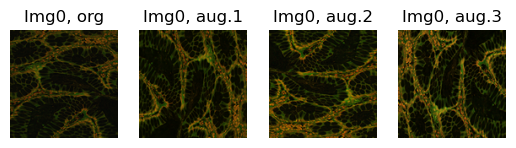

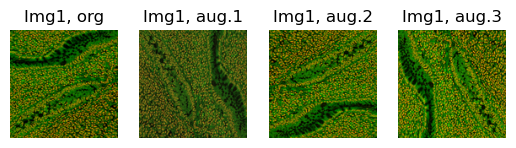

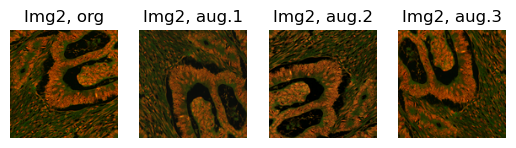

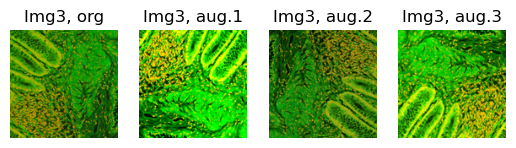

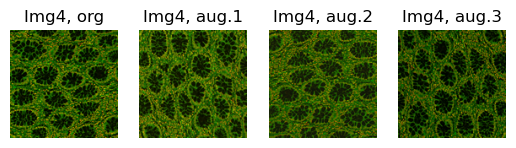

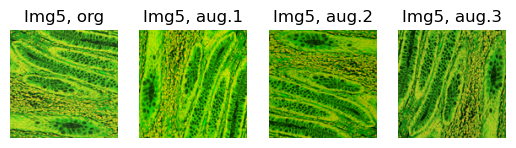

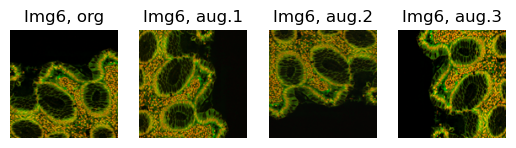

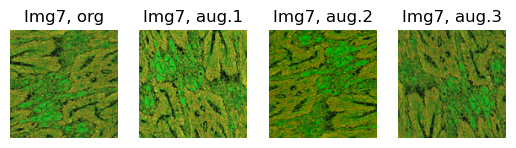

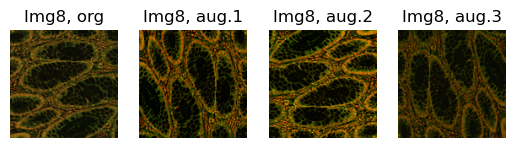

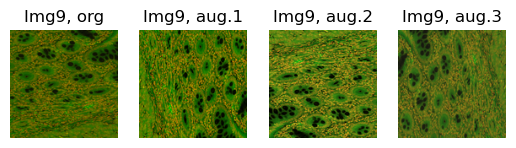

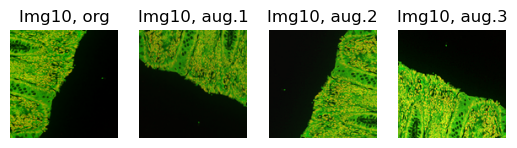

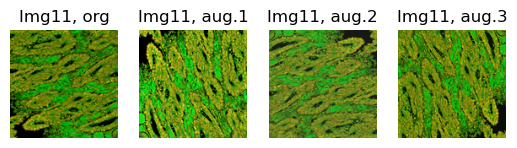

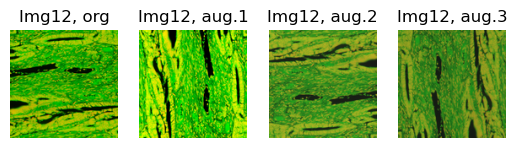

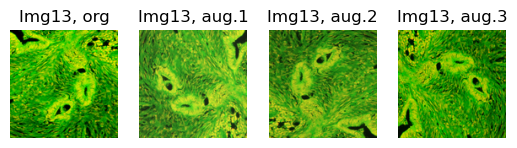

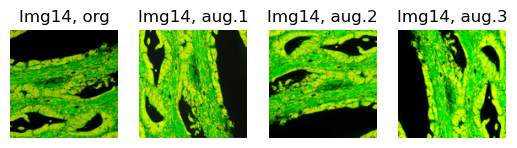

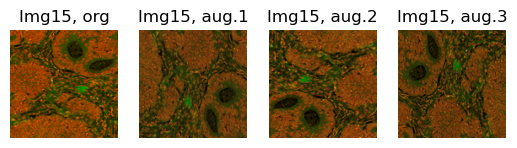

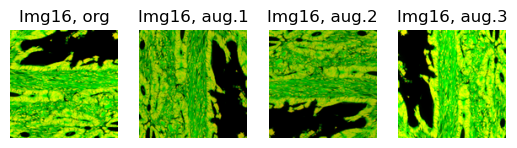

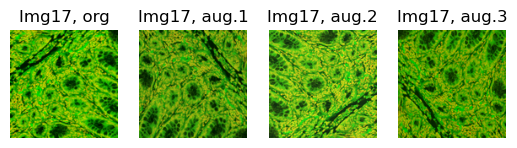

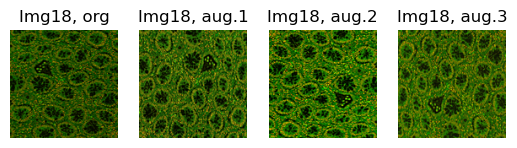

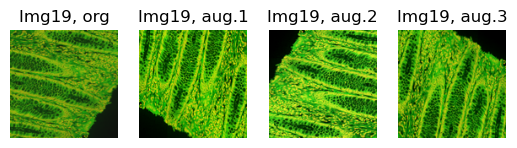

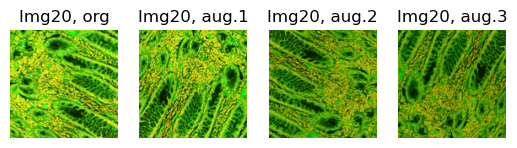

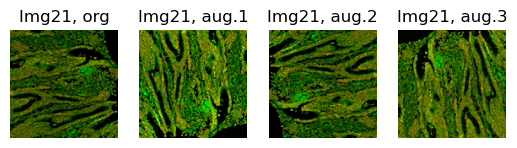

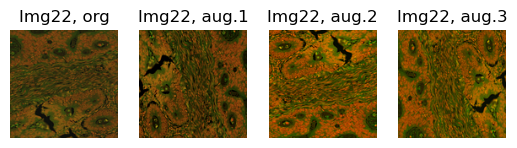

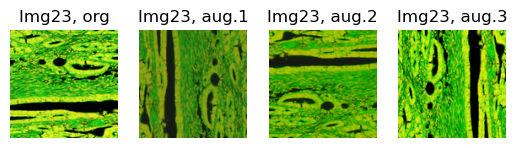

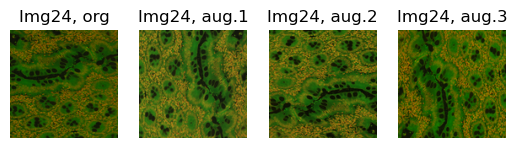

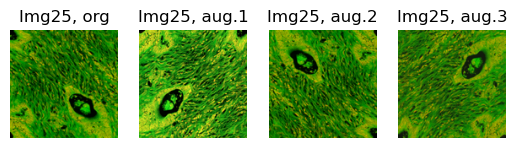

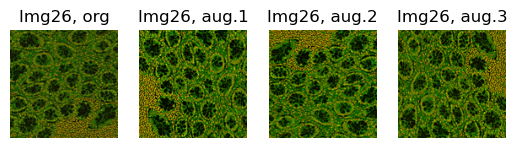

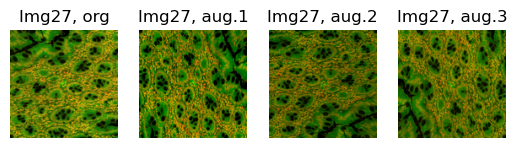

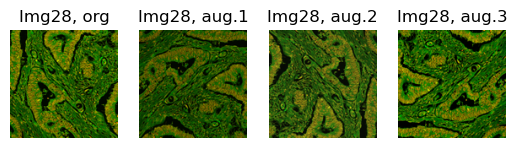

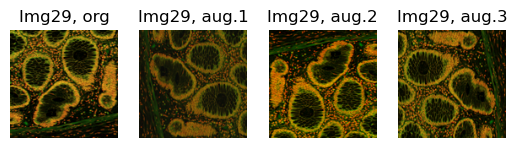

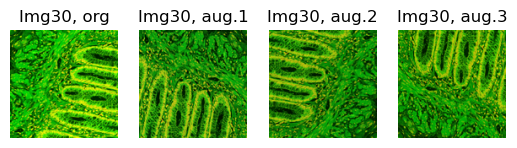

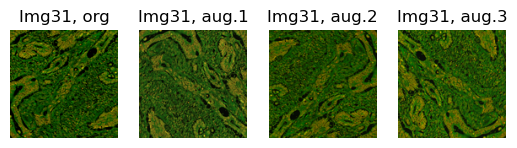

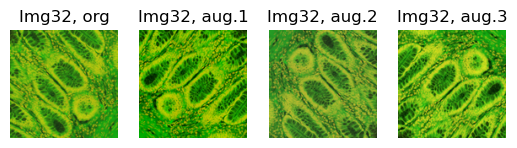

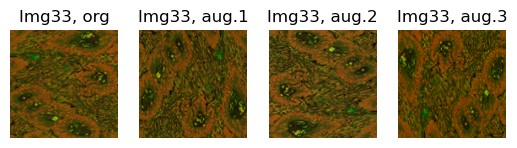

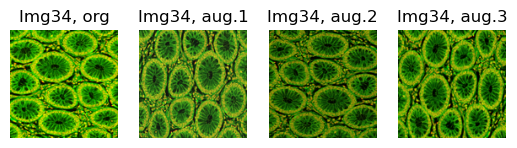

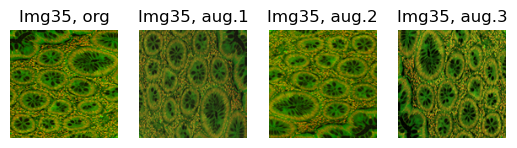

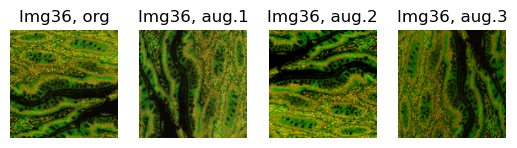

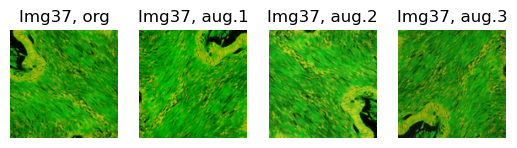

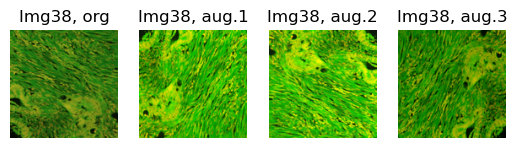

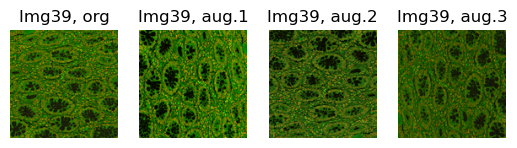

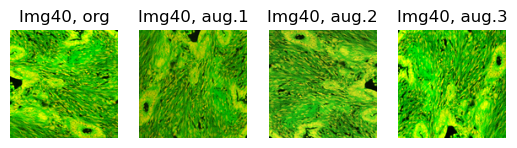

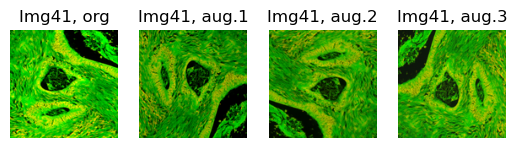

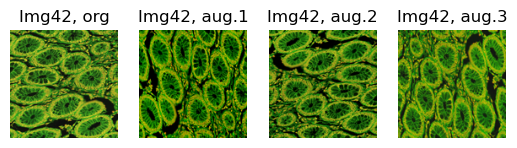

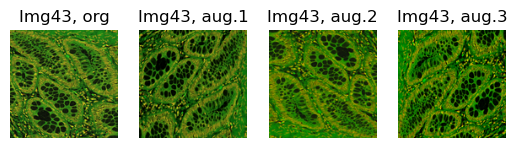

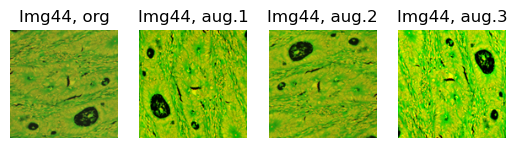

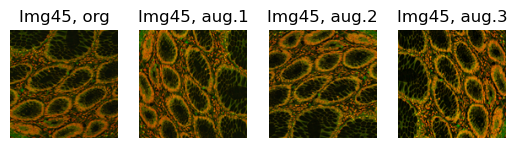

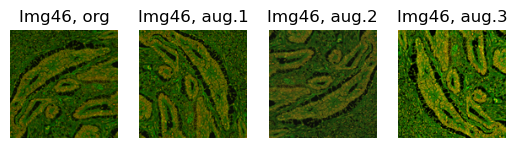

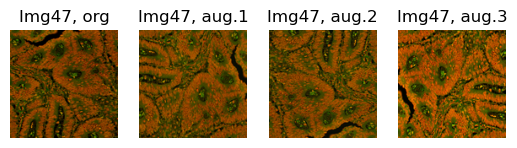

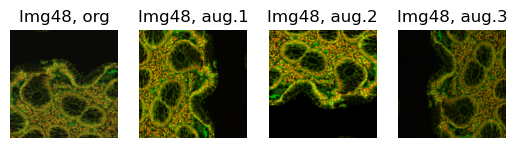

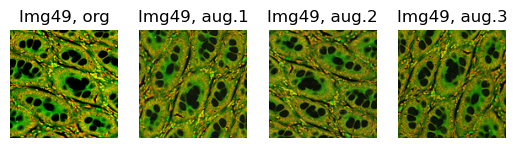

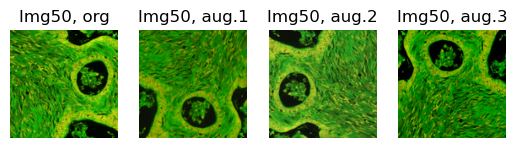

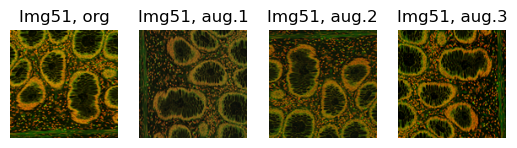

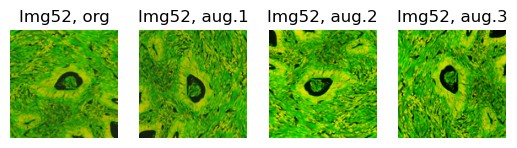

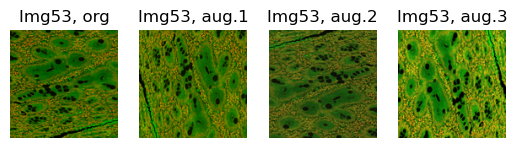

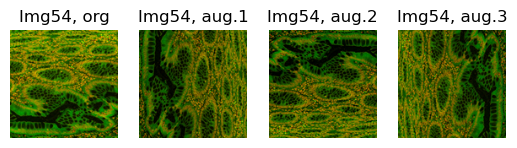

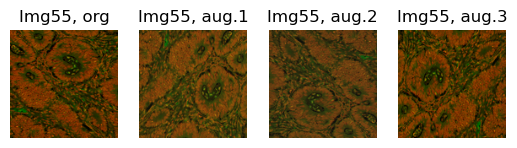

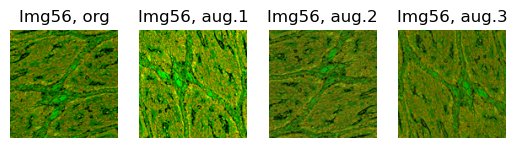

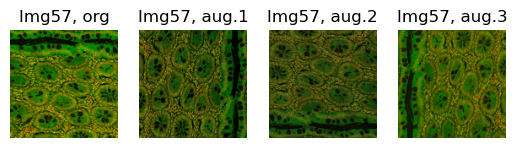

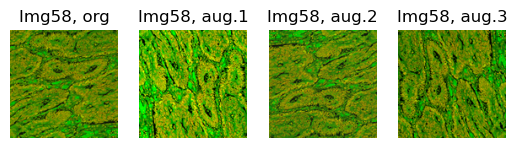

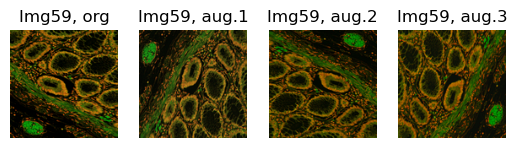

In [49]:
idx = 0
for i, (data, segmentations) in enumerate(test_loader):
    for idx in range(len(test_dataset)//4):
        img1 = data[4*idx]
        img2 = data[4*idx+1]
        img3 = data[4*idx+2]
        img4 = data[4*idx+3]

        # Move channel to end
        img1 = np.transpose(img1, (2, 1, 0))
        img2 = np.transpose(img2, (2, 1, 0))
        img3 = np.transpose(img3, (2, 1, 0))
        img4 = np.transpose(img4, (2, 1, 0))

        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)

        # Display image
        ax1.imshow(img1)
        ax1.axis("off")
        ax1.set_title(f"Img{idx}, org")

        # Display image
        ax2.imshow(img2)
        ax2.axis("off")
        ax2.set_title(f"Img{idx}, aug.1")

        # Display image
        ax3.imshow(img3)
        ax3.axis("off")
        ax3.set_title(f"Img{idx}, aug.2")

        # Display image
        ax4.imshow(img4)
        ax4.axis("off")
        ax4.set_title(f"Img{idx}, aug.3")

        plt.show()

# Define Neural Network

In [50]:
class SegmentationCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        # CONVOLUTION
        # Layer 1: 8 filters with dim=3x3x1 -> dim(Z1) = 128x128x8
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1)

        # Layer 2: Max Pooling with dim=2x2 -> dim(Z2) = 64x64x8

        # Layer 3: 16 filters with dim=3x3x8 -> dim(Z3) = 64x64x16
        self.conv3 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)

        # Layer 4: Max Pooling with dim=2x2 -> dim(Z4) = 32x32x16

        # Layer 5: 32 filters with dim=3x3x16 -> dim(Z5) = 32x32x32
        self.conv5 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)

        
        # TRANSPOSED CONVOLUTION (Upsampling)
        # Layer 6: 16 filters with dim=4x4x32 -> dim(Z6) = 64x64x16
        self.convT6 = nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1)

        # Layer 7: 16 filter with dim=4x4x16 -> dim(Z7) = 128x128x16
        self.convT7 = nn.ConvTranspose2d(16, 16, kernel_size=4, stride=2, padding=1)

        
        # 1x1 CONVOLUTION 
        # Layer 8: 2 filters with dim=1x1x16 -> dim(Z8) = 128x128x2
        self.conv8 = nn.Conv2d(16, 2, kernel_size=1)
        
        
        # Define other functions
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2, stride=2)
        self.softmax = nn.Softmax(dim=1) # Channel direction probabilities

    def forward(self, X):
        # Layer 1
        Z1 = self.conv1(X)
        A1 = self.relu(Z1)

        # Layer 2
        A2 = self.maxpool(A1)

        # Layer 3
        Z3 = self.conv3(A2)
        A3 = self.relu(Z3)

        # Layer 4
        A4 = self.maxpool(A3)

        # Layer 5
        Z5 = self.conv5(A4)
        A5 = self.relu(Z5)

        # Layer 6
        Z6 = self.convT6(A5)
        A6 = self.relu(Z6)

        # Layer 7
        Z7 = self.convT7(A6)
        A7 = self.relu(Z7)

        # Layer 8
        Z8 = self.conv8(A7)
        Y_hat = self.softmax(Z8)

        return Y_hat

# Accuracy function

In [51]:
def get_DSC(model_segmentation, true_segmentation):
    intersection = (model_segmentation * true_segmentation).sum().item()
    union = model_segmentation.sum().item() + true_segmentation.sum().item()

    dsc = (2 * intersection) / union

    return dsc

In [52]:
def get_DSC_vec(data_loader, model, device):
    DSC_vec = []
    
    model = model.to(device)

    # For each batch
    for data, true_segmentations in data_loader:
        data = data.to(device)
        true_segmentations = true_segmentations.to(device)
        
        raw_output = model(data)
        model_segmentations = torch.argmax(raw_output, dim=1).unsqueeze(1)

        # For each image in batch
        for i in range(data.shape[0]):
            model_seg = model_segmentations[i]
            true_seg = true_segmentations[i]

            DSC_vec.append(get_DSC(model_seg, true_seg))
    
    return DSC_vec

In [53]:
def get_average_DSC(data_loader, model, device):
    """ Get average DSC for all images in a data_loader """
    total_dsc = 0
    total_images = 0
    
    model = model.to(device)

    # For each batch
    for data, true_segmentations in data_loader:
        data = data.to(device)
        true_segmentations = true_segmentations.to(device)
        
        raw_output = model(data)
        model_segmentations = torch.argmax(raw_output, dim=1).unsqueeze(1)

        # For each image
        for i in range(data.shape[0]):
            model_seg = model_segmentations[i]
            true_seg = true_segmentations[i]

            dsc = get_DSC(model_seg, true_seg)
            total_dsc += dsc
            total_images += 1

    # Calculate average
    average_dsc = total_dsc / total_images
    
    return average_dsc

# Train model

In [54]:
def train_model(train_loader, test_loader, learning_rate, epochs, device, loss_vec, train_DSC_vec, test_DSC_vec):
    
    # Define model
    model = SegmentationCNN().to(device)  # Select model and move to "device"
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Performance with random weights
    test_DSC = get_average_DSC(test_loader, model, device)
    print(f'Epoch [0/{epochs}],                                  , Test DSC: {test_DSC:.5f}')
    
    # Training loop
    for epoch in range(1, epochs+1):
        for idx, (data, labels) in enumerate(train_loader):
            # Move to "device"
            data = data.to(device)
            labels = labels.to(device)
            labels = labels.squeeze(1).long()  # Fix format for loss function
            
            # Model forward and backward
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
        # Save loss after every epoch
        loss_vec.append(loss.item())
            
        # Accuracy on last mini-batch of train data
        train_DSC = get_average_DSC([(data, labels)], model, device)
        train_DSC_vec.append(train_DSC)
        
        # Accuracy on all test data
        test_DSC = get_average_DSC(test_loader, model, device)
        test_DSC_vec.append(test_DSC)
            
        # Print epoch results
        if epoch%20==0:
            print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.5f}, Train DSC: {train_DSC:.5f}, Test DSC: {test_DSC:.5f}')
    
    return model


In [57]:
# Hyperparameters
batch_size = 16
learning_rate = 0.001
epochs = 100

# List for storing loss
loss_vec = []
train_DSC_vec = []
test_DSC_vec = []

# Select where to train
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on device: {device}\n")

# Load the dataset
root_dir = "C:/Users/edvin/GitHub/DeepImg/A3/WARWICK/"
train_dataset = WarwickDataset(root_dir, split='Train')
test_dataset = WarwickDataset(root_dir, split='Test')

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

# Train model
start = time()
model = train_model(train_loader, test_loader, learning_rate, epochs, device, loss_vec, train_DSC_vec, test_DSC_vec)
print(f"\nTotal training time: {time()-start} seconds")


Training on device: cuda

Epoch [0/100],                                  , Test DSC: 0.00000
Epoch [20/100], Loss: 0.58892, Train DSC: 0.69364, Test DSC: 0.74850
Epoch [40/100], Loss: 0.42246, Train DSC: 0.80818, Test DSC: 0.78571
Epoch [60/100], Loss: 0.49139, Train DSC: 0.83202, Test DSC: 0.78733
Epoch [80/100], Loss: 0.50099, Train DSC: 0.73198, Test DSC: 0.79102
Epoch [100/100], Loss: 0.56698, Train DSC: 0.75904, Test DSC: 0.81726

Total training time: 114.23906326293945 seconds


# Print loss

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


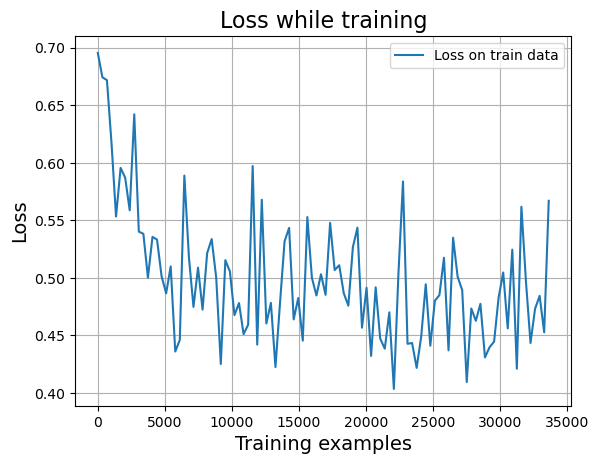

In [60]:
# Define data
x = range(0, len(loss_vec) * len(train_dataset), len(train_dataset))
y = loss_vec

# Define figure
fig1 = plt.figure()
plt.plot(x,y, label="Loss on train data")
plt.xlabel("Training examples", fontsize=14)
plt.ylabel("Loss", fontsize=14) 
plt.legend()
plt.grid()
plt.title("Loss while training", fontsize=16) 
plt.savefig("Segmentation_Loss_aug.eps")

# Plot DSC

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Final train DSC: 0.7590376195598607
Final test DSC: 0.8172614387832255


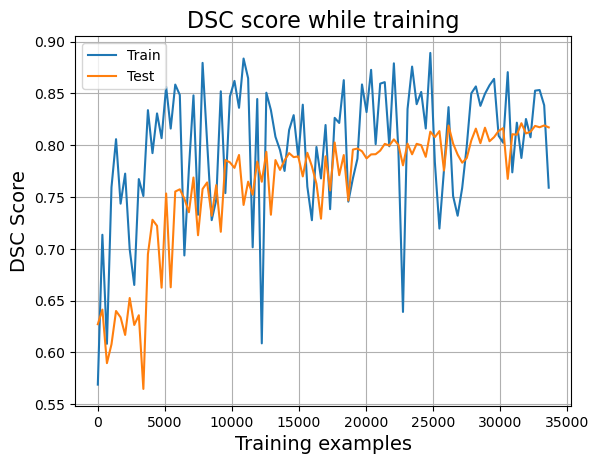

In [61]:
# Define data
x1 = range(0, len(loss_vec) * len(train_dataset), len(train_dataset))
y1 = train_DSC_vec

x2 = range(0, len(loss_vec) * len(train_dataset), len(train_dataset))
y2 = test_DSC_vec

# Define figure
fig1 = plt.figure()
plt.plot(x1,y1, label="Train")
plt.plot(x2,y2, label="Test")

plt.xlabel("Training examples", fontsize=14)
plt.ylabel("DSC Score", fontsize=14) 
plt.legend()
plt.grid()
plt.title("DSC score while training", fontsize=16) 
plt.savefig("Segmentation_DSC_aug.eps")


print(f"Final train DSC: {train_DSC_vec[-1]}")
print(f"Final test DSC: {test_DSC_vec[-1]}")

# View final segmentation

In [44]:
def find_worst(data_loader, model, device, count):
    # Get list of all DSC values for all indices in the data_loader
    DSC_vec = get_DSC_vec(data_loader, model, device)

    # Sort the DSC value by the lowest and save the index
    sorted_DSC_vec = sorted(enumerate(DSC_vec), key=lambda x: x[1])

    # Find the worst
    worst = sorted_DSC_vec[:count]

    return worst

In [45]:
def find_best(data_loader, model, device, count):
    # Get list of all DSC values for all indices in the data_loader
    DSC_vec = get_DSC_vec(data_loader, model, device)

    # Sort the DSC value by the lowest and save the index
    sorted_DSC_vec = sorted(enumerate(DSC_vec), key=lambda x: x[1])

    # Find the worst
    best = sorted_DSC_vec[-count:-1]

    return best

## Display worst five

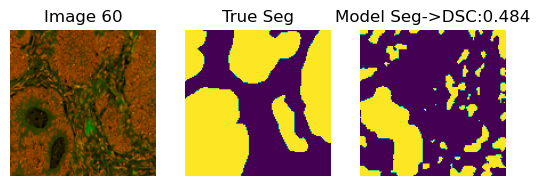

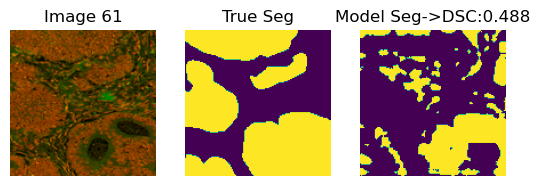

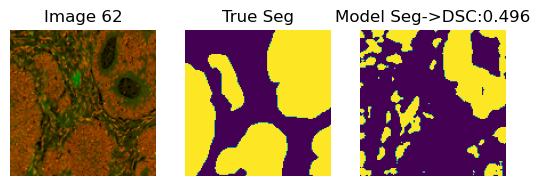

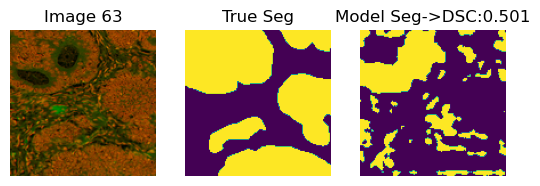

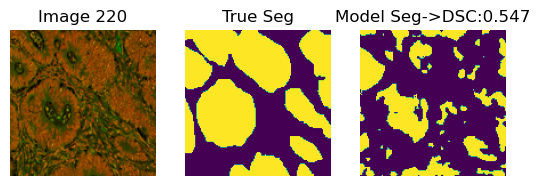

In [54]:
worst = find_worst(test_loader, model, device, 5)
indices = [index for index, _ in worst]
values = [value for _,value in worst]
count = 0

model.to("cpu")

for data, true_segmentations in test_loader:
    raw_output = model(data.to("cpu"))
    model_segmentations = torch.argmax(raw_output, dim=1).unsqueeze(1)
    for idx in range(len(data)):
        if idx in indices:
            img = data[idx]
            true_segmentation = true_segmentations[idx][0]
            model_segmentation = model_segmentations[idx][0]

            img = np.transpose(img, (1, 2, 0))

            fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

            # Display image
            ax1.imshow(img)
            ax1.axis("off")
            ax1.set_title(f"Image {idx}")

            # Display segmentation
            ax2.imshow(true_segmentation)
            ax2.axis("off")
            ax2.set_title("True Seg")

            # Display model segmentaiton
            ax3.imshow(model_segmentation)
            ax3.axis("off")
            ax3.set_title(f"Model Seg->DSC:{values[count]:.3f}")
            count+=1
      
            plt.show()



## Display best five

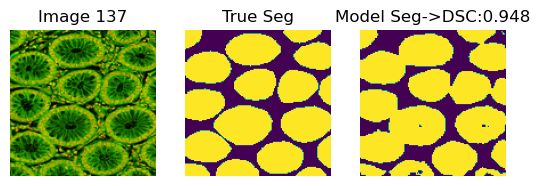

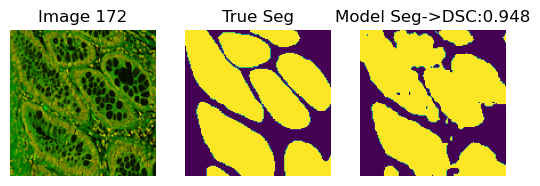

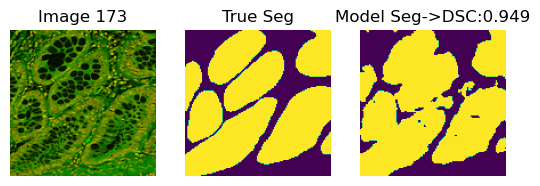

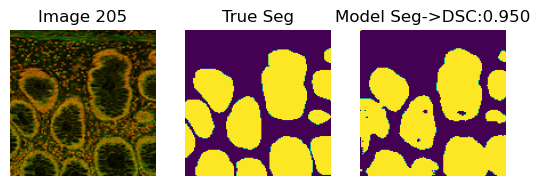

In [60]:
best = find_best(test_loader, model, device, 5)
indices = [index for index, _ in best]
values = [value for _,value in best]
count = 0

model.to("cpu")

for data, true_segmentations in test_loader:
    raw_output = model(data.to("cpu"))
    model_segmentations = torch.argmax(raw_output, dim=1).unsqueeze(1)
    
    for idx in range(len(data)):
        if idx in indices:
            img = data[idx]
            true_segmentation = true_segmentations[idx][0]
            model_segmentation = model_segmentations[idx][0]

            img = np.transpose(img, (1, 2, 0))

            fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

            # Display image
            ax1.imshow(img)
            ax1.axis("off")
            ax1.set_title(f"Image {idx}")

            # Display segmentation
            ax2.imshow(true_segmentation)
            ax2.axis("off")
            ax2.set_title("True Seg")

            # Display model segmentaiton
            ax3.imshow(model_segmentation)
            ax3.axis("off")
            ax3.set_title(f"Model Seg->DSC:{values[count]:.3f}")
            count+=1
      
            plt.show()

